In [2]:
# import all necessary packages for CBOW
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import collections
import itertools
import re
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from gensim import matutils
from numpy import dot

ImportError: cannot import name 'triu' from 'scipy.linalg' (/opt/conda/lib/python3.9/site-packages/scipy/linalg/__init__.py)

In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print device name: get_device_name()
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-32GB


In [4]:
# Load data from file and store list of sentences where sentences are list of words
class MakeSentences():
    def __init__(self, file_name):
        self.file_name = file_name
        self.sentences = self.read_file()

    def read_file(self):
        sentences = []
        with open(self.file_name, 'r') as f:
            i=0
            for line in f:
                sentences += ([x for x in line.strip().split('.') if x!=''])
                i+=1
                if i==10000:
                    break
        return sentences

In [6]:
sentences = MakeSentences('/projects/rtelidevara/pk/Part_A/wikitext-2-raw-v1/wikitext-2-raw/wiki.train.raw').sentences
print(len(sentences))
# for sentence in sentences:
#     print(type(sentence))

25137


### Preprocess

In [7]:
import re
from collections import Counter

class Preprocess():
    def __init__(self, sentences):
        self.sentences = sentences

    def tokenize(self):
        # Split sentences into words using regex to handle various punctuation
        self.sentences = [re.findall(r'\b\w+\b', sentence.lower()) for sentence in self.sentences]

    def lowercase(self):
        self.sentences = [[word.lower() for word in sentence] for sentence in self.sentences]

    def remove_stop_words(self):
        # Common English stop words; expand as necessary
        stop_words = set(["the", "is", "at", "which", "on", "and", "a", "an"])
        self.sentences = [[word for word in sentence if word not in stop_words] for sentence in self.sentences]

    def stemmer(self):
        # Simple stemming using suffix stripping, can be improved
        def simple_stem(word):
            suffixes = ["ing", "ly", "ed", "ious", "ies", "ive", "es", "s", "ment"]
            for suffix in sorted(suffixes, key=len, reverse=True):
                if word.endswith(suffix):
                    return word[:-len(suffix)]
            return word
        self.sentences = [[simple_stem(word) for word in sentence] for sentence in self.sentences]

    def remove_punctuation(self):
        self.sentences = [[word for word in sentence if word.isalpha()] for sentence in self.sentences]

    def remove_numbers(self):
        self.sentences = [[word for word in sentence if not word.isdigit()] for sentence in self.sentences]

    def remove_single_letter(self):
        self.sentences = [[word for word in sentence if len(word) > 1] for sentence in self.sentences]

    def remove_extra_spaces(self):
        self.sentences = [[word for word in sentence if word.strip()] for sentence in self.sentences]

    def remove_less_than_3(self):
        self.sentences = [[word for word in sentence if len(word) > 2] for sentence in self.sentences]


In [8]:
# preprocess
preprocess = Preprocess(sentences)
preprocess.tokenize()
# print(preprocess.sentences)
preprocess.lowercase()
preprocess.remove_stop_words()
# preprocess.stemmer()
preprocess.remove_punctuation()
preprocess.remove_numbers()
preprocess.remove_single_letter()
preprocess.remove_extra_spaces()
preprocess.remove_less_than_3()

print("Preprocessing done")
# print(preprocess.sentences)
sentences = preprocess.sentences
print(len(sentences))
# print(sentences)

Preprocessing done
25137


### Create word index mappings

In [9]:
# Flatten list of sentences into list of words
word_list = list(itertools.chain.from_iterable(sentences))
# print(word_list)

# Create a vocabulary of words
word_freq = Counter(word_list)

# Remove words that occur less than 5 times
vocab = set(word if word_freq[word] > 0 else '<unk>' for word in word_list)
# print(vocab)

# Add padding and unknown token to vocab
vocab.add('<pad>')
vocab.add('<unk>')
# Add start and end token to vocab
vocab.add('<start>')
vocab.add('<end>')

# Print length of vocab
print("Size of vocab: ", len(vocab))

# Create word to index and index to word mapping
word_to_idx = {word:idx for idx, word in enumerate(vocab)}
idx_to_word = {idx:word for idx, word in enumerate(vocab)}

# Print most common words
print("Most common words: ", word_freq.most_common(10))

Size of vocab:  30214
Most common words:  [('was', 5340), ('that', 3928), ('for', 3841), ('with', 3758), ('from', 2329), ('his', 2328), ('were', 1987), ('had', 1638), ('are', 1262), ('her', 1248)]


In [10]:
# Check
print(word_to_idx['intelligent'])

5348


### Create dataset (X,y)

In [11]:
import random
# define constants
window_size = 2
sliding_window = 2 * window_size + 1
num_neg_samples = 1
# print(sentences)

# sentences = [sentences[0]]
# print(sentences)
def select_negative_samples(target_word, num_window_size, unigram_table):
    negative_samples = []
    while len(negative_samples) < 2*num_window_size:
        sampled_word = random.choice(unigram_table)  # unigram_table is precomputed based on the distribution
        if sampled_word != target_word:
            negative_samples.append(sampled_word)
    return negative_samples

def create_unigram_table(vocab, table_size=len(vocab)):
    unigram_table = []
    total_count_power = sum([count**0.75 for count in vocab.values()])
    for word, count in vocab.items():
        p_wi = (count**0.75) / total_count_power
        # Fill the table with the index of the word
        unigram_table.extend([word] * int(p_wi * table_size))
    return unigram_table

unigram_table = create_unigram_table(word_freq)
# print(unigram_table)

def get_samples(sentences, word_to_idx, idx_to_word, window_size, sliding_window, num_neg_sample , vocab , unigram_table):
    X = []
    y = []
    for sentence in sentences:
        # add start and end token to sentence
        sentence = ['<start>'] + sentence + ['<end>']
        for i in range(len(sentence)):
            context_word = sentence[i]
            # print("target word: ", target_word)
            target_words = []
            temp1 = max(0,i - window_size)
            temp2 = min(len(sentence)-1,i + window_size + 1)
            # print("temp1: ", temp1)
            # print("temp2: ", temp2)
            for j in range(max(0,i - window_size),min(len(sentence)-1,i + window_size)+1):
                if j != i:
                    # print(sentence[j])
                    target_words.append(sentence[j])
                # print("context words: ", context_words)


            # pad context words if length is less than sliding window
            if len(target_words) < sliding_window:
                target_words += ['<pad>'] * (sliding_window - len(target_words)-1)

            target_words.append(context_word)
            # print("length of target words: ", len(target_words))

            # get positive samples
            positive_samples = [word_to_idx[word] if word in vocab else word_to_idx['<unk>'] for word in target_words]
            # print("lenght of positive samples: ", len(positive_samples))

            X.append(positive_samples)
            y.append(1)


            # get negative samples
            for i in range(num_neg_samples):
                negative_samples = select_negative_samples(context_word, window_size, unigram_table)
                negative_samples = [word_to_idx[word] if word in vocab else word_to_idx['<unk>'] for word in negative_samples]
                negative_samples += [word_to_idx['<pad>']] * (sliding_window - len(negative_samples)-1)
                negative_samples.append(word_to_idx[context_word])
                X.append(negative_samples)
                y.append(0)
                # print("length of negative samples: ", len(negative_samples))


    return X, y

In [12]:
print("Creating samples")
X, y = get_samples(sentences, word_to_idx, idx_to_word, window_size, sliding_window, num_neg_samples, vocab, unigram_table)
print(X[2])
print(y[2])
print("Samples created")

Creating samples
[7967, 1290, 7861, 28126, 26896]
1
Samples created


In [13]:
# shuffle data
data = list(zip(X,y))
random.shuffle(data)
X,y = zip(*data)

# Turn into numpy arrays
X = np.array(X)
y = np.array(y)

In [14]:
# Save X and y
np.save('/projects/rtelidevara/pk/Part_A/skipgram/datasets/wikiskip_X_25k.npy', X)
np.save('/projects/rtelidevara/pk/Part_A/skipgram/datasets/wikiskip_y_25k.npy', y)

In [15]:
# Load X and y
X = np.load('/projects/rtelidevara/pk/Part_A/skipgram/datasets/wikiskip_X_25k.npy')
y = np.load('/projects/rtelidevara/pk/Part_A/skipgram/datasets/wikiskip_y_25k.npy')

### Build Model

In [16]:
# write the forward pass for SkipGram
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
        # self.embeddings.weight.data.uniform_(-1, 1)

    def forward(self, x):
        # extract context and target from x
        context = x[:, :-1]
        input = x[:, -1]

        context_embedding = self.embeddings(context)
        input_embedding = self.embeddings(input)

        # Dot product between each context embedding and input embedding to get batch_size*context_size*embedding_dim

        dot_products = torch.bmm(context_embedding, input_embedding.unsqueeze(2))  # [batch_size, context_length, 1]
        sum_dot_products = torch.sum(dot_products, dim=1)  # [batch_size, 1]

        # Squeeze the last dimension to get the final scores
        scores = sum_dot_products.squeeze(1)  # [batch_size]

        return F.sigmoid(scores)

    def get_embeddings(self):
        out = self.embeddings.weight.data
        return out.cpu().numpy()

    def get_word_embedding(self, word):
        # If word is not in vocab, return unk
        if word not in word_to_idx:
            word = '<unk>'
        word_tensor = torch.LongTensor([word_to_idx[word]])
        word_tensor = word_tensor.to(next(self.parameters()).device)
        out = self.embeddings(word_tensor).data
        return out.cpu().numpy()

In [17]:
# Define parameters
vocab_size = len(vocab)
embedding_dim = 250
learning_rate = 0.001
epochs = 10
batch_size = 128

# Create model, loss function and optimizer
model = SkipGram(vocab_size, embedding_dim)
model.to(device)
# Cross entropy loss
criterion = nn.BCELoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define dataloader
dataset = torch.utils.data.TensorDataset(torch.from_numpy(X).long(), torch.from_numpy(y).float())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [18]:
# Check dataset
for i, (inputs, targets) in enumerate(dataloader):
    print(inputs)
    print(targets)
    break

tensor([[24575,  3439,  5128, 14172,  3346],
        [14204, 12050, 24280, 21082, 10450],
        [ 6267, 18872, 28126, 28126,  7967],
        [ 8047, 26151, 19686,  3695, 20966],
        [ 2466, 26290, 17390,  3695,  3346],
        [ 3126,  7582, 27518,  6272, 26227],
        [25461,  8871,  6625, 19913,   706],
        [26876, 13400, 12065,  7700,  7903],
        [26092,  7212, 14798,   587, 12436],
        [15275,  7456,  1723, 14798,  6658],
        [ 7967,  3346, 28126, 28126, 29379],
        [12964, 17033, 12765,  1685,  7967],
        [22978, 28802, 23995, 12964, 23393],
        [13942, 25253, 12122, 13944,   186],
        [26844, 28124, 23898, 25519, 11473],
        [22288, 26819, 26053, 18189,  1907],
        [12787, 26053, 19700, 19988,  2176],
        [27332, 17081,  6694, 14920, 17340],
        [26199, 20431, 23656, 14745, 12765],
        [16094, 24530, 20533, 23903, 23610],
        [ 4835, 29120, 28398, 25717,  7166],
        [27522,  8835, 27967, 12593, 29644],
        [2

In [19]:
# Train SkipGram model
def train(model, criterion, optimizer, dataloader, epochs):
    train_losses = []
    for epoch in range(epochs):
        train_loss = 0
        train_preds = []
        labels = []
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # get predictions
            preds = [1 if x > 0.5 else 0 for x in outputs]
            train_preds.extend(preds)
            targets = targets.detach().cpu().numpy()
            labels.extend(targets)
        
        train_loss /= len(dataloader)
        train_losses.append(train_loss)
        print("Epoch: ", epoch+1, "Loss: ", train_loss)
    return train_losses

In [20]:
# Train model
train_losses = train(model, criterion, optimizer, dataloader, epochs)

Epoch:  1 Loss:  19.678914518946566
Epoch:  2 Loss:  15.693411780415058
Epoch:  3 Loss:  13.645750204694453
Epoch:  4 Loss:  12.44208805124186
Epoch:  5 Loss:  11.613752767049885
Epoch:  6 Loss:  10.977796158057759
Epoch:  7 Loss:  10.471524297403526
Epoch:  8 Loss:  10.070528259073411
Epoch:  9 Loss:  9.75852910303854
Epoch:  10 Loss:  9.48933094221793


In [21]:
# Function to plot train accuracy
def plot_train_losses(train_losses):
    plt.plot(train_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.savefig('/projects/rtelidevara/pk/Part_A_Word_Similarity/skipgram/plots/skip_train_losses.png')
    plt.show()

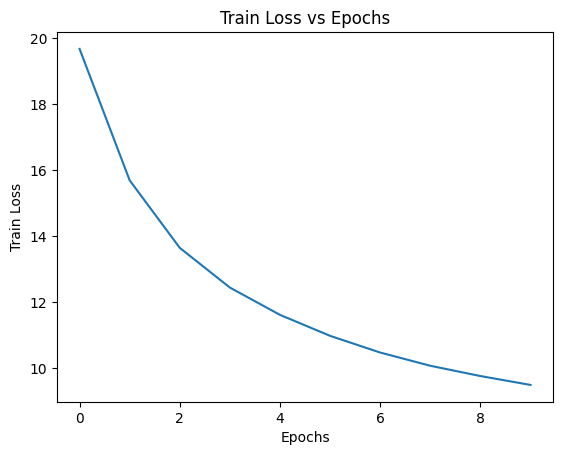

In [22]:
# Call function to plot train accuracy
plot_train_losses(train_losses)

In [23]:
torch.save(model.state_dict(), '/projects/rtelidevara/pk/Part_A_Word_Similarity/skipgram/partA_pth/skipgram_25k_250_001.pth')

In [24]:
# Load model
model = SkipGram(vocab_size, embedding_dim)
model.load_state_dict(torch.load('/projects/rtelidevara/pk/Part_A_Word_Similarity/skipgram/partA_pth/skipgram_25k_250_001.pth'))
model.to(device)

SkipGram(
  (embeddings): Embedding(30214, 250)
)

In [25]:
# Load test data

# Load into dataframe
df = pd.read_csv('../wordsim353/combined.csv')
print(df.head())

     Word 1    Word 2  Human (mean)
0      love       sex          6.77
1     tiger       cat          7.35
2     tiger     tiger         10.00
3      book     paper          7.46
4  computer  keyboard          7.62


In [26]:
# Print 2nd row word1
print(df['Word 1'][1])

tiger


In [27]:
# Get word embeddings
sample_embedding = model.get_word_embedding(df['Word 1'][1])
print(sample_embedding.shape)
sample_embedding = sample_embedding.squeeze()
print(sample_embedding.shape)
print(sample_embedding)

(1, 250)
(250,)
[ 2.1453993e+00  2.6786470e-01 -1.0625212e+00 -2.1037853e+00
 -6.7155105e-01 -6.5479088e-01  1.0854462e+00 -6.8585312e-01
  9.9161994e-01 -6.3560200e-01  1.0240329e-01 -1.5952851e-01
  5.2295572e-01  3.3799502e-01  4.9305511e-01 -1.7535865e+00
  1.2335373e-02  3.0279108e-03 -1.9114759e+00  7.9899889e-01
 -7.6640004e-01  1.0752903e-01 -8.2727212e-01  4.5669818e-01
 -4.7263473e-02  1.1343976e+00 -1.2073023e+00 -1.0681583e+00
  3.2310078e-01  9.5481497e-01 -5.1702780e-01  4.1009197e-01
  6.8618953e-01 -1.0057175e+00 -1.2037067e+00  2.1191777e-01
  8.3559060e-01  1.8974041e+00 -6.2855315e-01 -4.4803536e-01
 -3.0882147e-01  7.8791803e-01 -5.4517460e-01 -9.4037992e-01
 -6.2344652e-01  4.7673497e-01  2.9498199e-01 -9.3626964e-01
 -3.7939906e-01  4.7937098e-01  3.5217080e-01 -1.2128434e+00
 -1.7233650e-01  1.7799528e-01 -1.5743387e+00 -3.3687451e+00
  1.3175291e-01  1.1105055e+00  6.8711364e-01 -1.0272923e+00
 -1.1521819e+00  1.2776363e+00  6.9064367e-01  7.6795596e-01
 -8.6964

In [28]:
import numpy as np

# Check similarity between two words
word1 = df['Word 1'][1]
word2 = df['Word 2'][1]

# Use gensim or any other model to get word embeddings
w1 = model.get_word_embedding(word1).squeeze()
w2 = model.get_word_embedding(word2).squeeze()

print(type(w1))

# Calculate cosine similarity using numpy
def unitvec(vec):
    return vec / np.linalg.norm(vec)

sim = np.dot(unitvec(w1), unitvec(w2))
print(sim)

<class 'numpy.ndarray'>
-0.041727383


In [29]:
# Function to check if word is in vocab
def check_vocab(word):
    if word in vocab:
        return True
    else:
        return False

In [30]:
# Function to get cosine similarity
import numpy as np

def cos_similarity(word1_embedding, word2_embedding):
    def unitvec(vec):
        return vec / np.linalg.norm(vec)

    ans = np.dot(unitvec(word1_embedding), unitvec(word2_embedding))
    return ans


# Function to get Pearson correlation
def pearson_correlation(word1_embedding, word2_embedding):
    emb1 = np.array(word1_embedding)
    emb2 = np.array(word2_embedding)

    correlation, _ = pearsonr(emb1, emb2)
    return correlation

In [31]:
def test_sim(df,model, lemmatizer, stemmer):
    cosine_similarity_scores = []
    pearson_correlation_scores = []
    scores = []

    for _, row in df.iterrows():
        word1 = row['Word 1']
        word2 = row['Word 2']

        # Get embeddings
        word1_embedding = model.get_word_embedding(word1).squeeze()
        word2_embedding = model.get_word_embedding(word2).squeeze()

        # Get cosine similarity
        cosine_similarity_scores.append(cos_similarity(word1_embedding, word2_embedding))

        # Get pearson correlation
        pearson_correlation_scores.append(pearson_correlation(word1_embedding, word2_embedding))

        # Get score
        scores.append(row['Human (mean)'])

    return cosine_similarity_scores, pearson_correlation_scores, scores

In [32]:
# Get cosine similarity and pearson correlation scores
lemmatizer = WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
cosine_similarity_scores, pearson_correlation_scores, scores  = test_sim(df, model, lemmatizer, stemmer)

In [33]:
# Check cosine similarity and pearson correlation scores
print(type(cosine_similarity_scores))
print(type(pearson_correlation_scores))
print(type(scores))

<class 'list'>
<class 'list'>
<class 'list'>


In [34]:
# Funtcion to get spearman correlation using cosine similarity scores
def spearman_correlation(cosine_similarity_scores, scores):
    # Scale cosine similarity scores to 0-10
    cosine_similarity_scores = np.array(cosine_similarity_scores)
    cosine_similarity_scores = (1+cosine_similarity_scores)*5
    scores = np.array(scores)

    correlation, _ = spearmanr(cosine_similarity_scores, scores)
    return correlation

In [35]:
# Print the initial spearman correlation
spearman_value_sim = spearman_correlation(cosine_similarity_scores, scores)

print("Initial Spearman correlation Sim: ", spearman_value_sim)

Initial Spearman correlation Sim:  0.032436123945252124


In [73]:
%dropzone -p -src 'skipgram_wordsim.ipynb' -tgt 'skipgram_wordsim.ipynb'

HTML(value='')

/opt/conda/lib/python3.9/subprocess.py:941: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
Host key verification failed.
Connection closed


DownloadWidget(children=(HBox(children=(Password(description='Dropzone Password:', style=DescriptionStyle(desc…